## Project 3: German Credit Dataset


> Project by  : **Kishan Kanaiyalal Patel**  
Student ID  : **200527734**


### Importing required libraries

In [1]:
#Importing all the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D 
import warnings
warnings.filterwarnings("ignore")

### Loading the dataset

In [2]:
#Readign the CSV file.

df= pd.read_csv("germanCreditDataset.csv")
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### Data Wrangling

In [3]:
#changing columns names for ease of code.

df=df.rename(columns = {'Age':'age', 'Sex':'sex', 'Job':'job', 'Housing':'housing', 'Saving accounts': 'saving_account',\
            'Checking account': 'checking_account', 'Credit amount': 'credit_amount', 'Duration':'duration',\
            'Purpose':'purpose', 'Risk':'risk'})
df.head()

,age,sex,job,housing,saving_account,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
#Displaying the number of rows and columns dataset has

print('This dataset has %d rows and %d columns.\n' %df.shape)

This dataset has 1000 rows and 10 columns.



In [5]:
#Displaying the basic information about the dataset to get familiar with it. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   job               1000 non-null   int64 
 3   housing           1000 non-null   object
 4   saving_account    817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


Dataset contains null values in saving_account and checking_account. Let's find out how many values we are missing.

In [6]:
#Displaying the number of null values in our dataset.
df.isnull().sum()

age                   0
sex                   0
job                   0
housing               0
saving_account      183
checking_account    394
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64

We can see from the results that we are having 183 null values in saving_account and 394 in checking_account columns.

In [7]:
#Let's find out the unique values of those columns 

print("Saving account has",df['saving_account'].unique(), "values")
df['saving_account'].value_counts()

Saving account has [nan 'little' 'quite rich' 'rich' 'moderate'] values


little        603
moderate      103
quite rich     63
rich           48
Name: saving_account, dtype: int64

In [8]:
#Let's find out the unique values of those columns 

print("Checking account has",df['checking_account'].unique(), "values")
df['checking_account'].value_counts()

Checking account has ['little' 'moderate' nan 'rich'] values


little      274
moderate    269
rich         63
Name: checking_account, dtype: int64

In [9]:
#For future analysis, we will need the datatype of job as object
df['job']= df['job'].astype(str)

### Exploratory Data Analysis

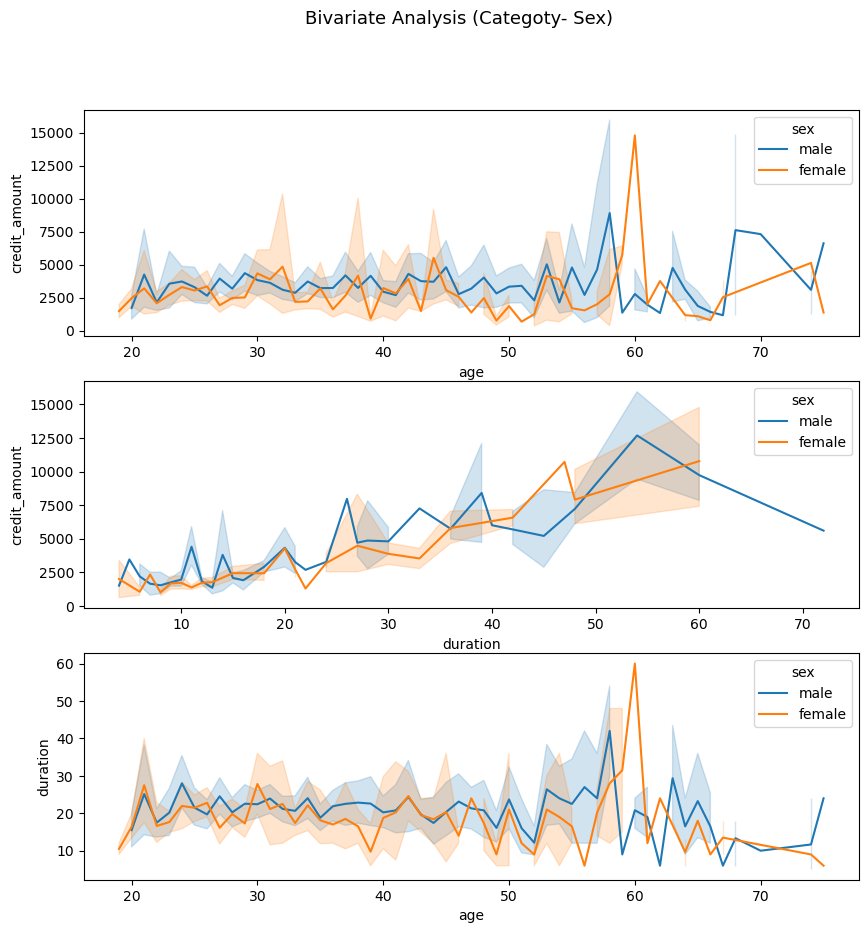

In [10]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('Bivariate Analysis (Categoty- Sex)', fontsize=13)

sns.lineplot(data=df, x='age', y='credit_amount', hue='sex', lw=1.5, ax=ax[0]);
sns.lineplot(data=df, x='duration', y='credit_amount', hue='sex', lw=1.5, ax=ax[1]);
sns.lineplot(data=df, x='age', y='duration', hue='sex', lw=1.5, ax=ax[2]);

Looking at the graphs, we can infer several findings.

1. At the age around 60, female has tendency of leveraging higher credit amount. However, throughout the lifespan male leverages credit amount slightly higher than female.
2. As duration passes, the credit amount increases and that is obvious because people take bigger loans for longer terms. Male has tendency of higher credit amount leverage and then sudden drop can be seen.
3. Age vs Duration shows normal tendency unless around the age of 60.

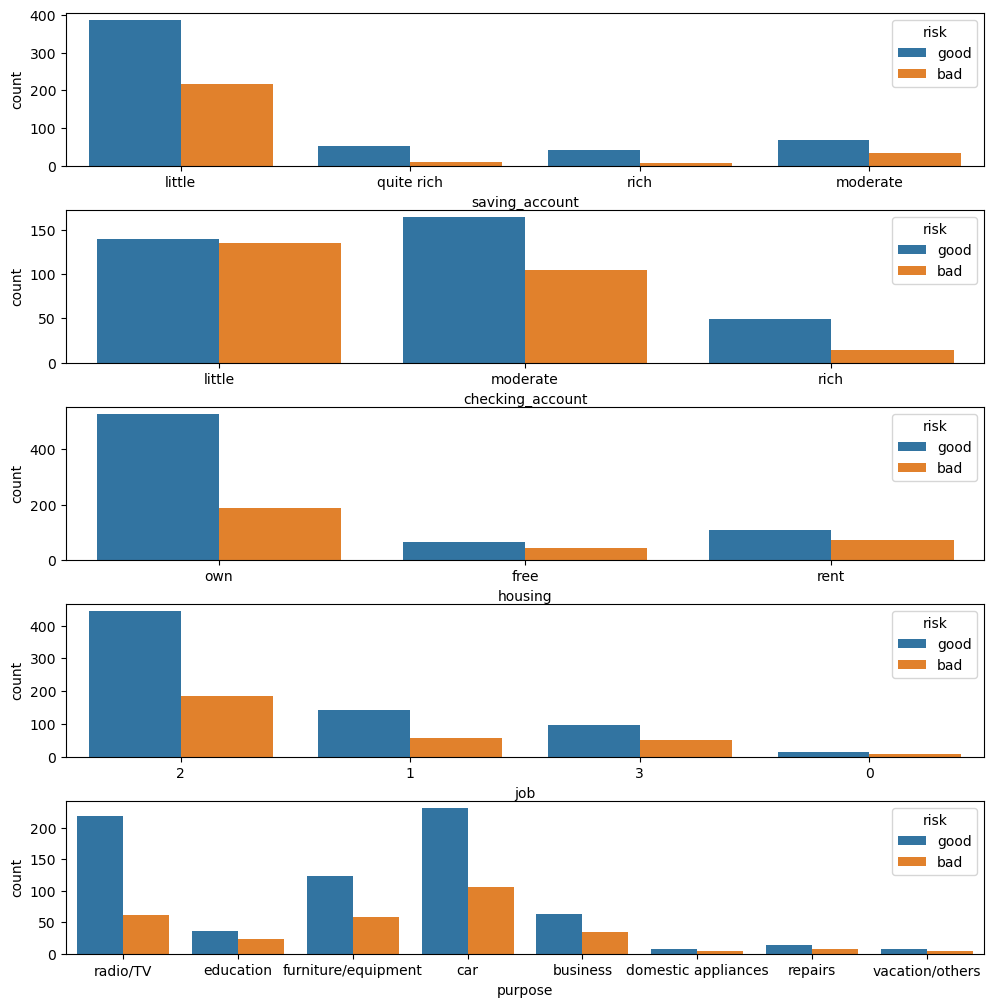

In [11]:
fig, ax =plt.subplots(5,1,figsize=(10,10))
plt.tight_layout()

sns.countplot(df['saving_account'], hue=df.risk, ax=ax[0]);
sns.countplot(df['checking_account'], hue=df.risk, ax=ax[1]);
sns.countplot(df['housing'], hue=df.risk, ax=ax[2]);
sns.countplot(df['job'], hue=df.risk, ax=ax[3]);
sns.countplot(df['purpose'], hue=df.risk, ax=ax[4]);

People with little amount in their savings account, people with moderate amount in checking account, who owns a hous tend to take more loans to purchase cars which can be seen in the barplots graphed above.

<AxesSubplot:>

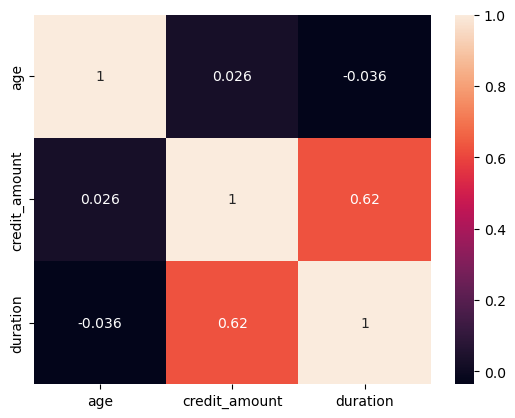

In [12]:
sns.heatmap(df.corr(method='spearman'), annot = True)

There is not much significance between numerical columns, however we can see little correlation between credit_amount and duration.

Moreover, it will not be viable if we impute random value or mode in saving account and checking account because this could mislead our assumptions. therefore, we will impute them with 'unavailable'.

In [13]:
df['saving_account'].fillna('unavailable', inplace = True)
df['checking_account'].fillna('unavailable', inplace = True)


### One-Hot-Encoding

In [60]:
#Duplicating the dataset.
encoded_df = df.copy()

In [15]:
#Applying One-Hot-Encoder only to categorical features (Not Label)

cat_columns = ['sex','job','housing','saving_account','checking_account','purpose']

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

In [17]:
for i in cat_columns :
    X = pd.DataFrame(encoder.fit_transform(np.array(encoded_df[i]).reshape(-1,1)), columns=i+'_'+encoded_df[i].unique())
    encoded_df = pd.concat([encoded_df,X], axis=1)
    encoded_df.drop(i,axis=1,inplace=True)

In [18]:
encoded_df.head()

,age,credit_amount,duration,risk,sex_male,sex_female,job_2,job_1,job_3,job_0,...,checking_account_unavailable,checking_account_rich,purpose_radio/TV,purpose_education,purpose_furniture/equipment,purpose_car,purpose_business,purpose_domestic appliances,purpose_repairs,purpose_vacation/others
0,67,1169,6,good,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,5951,48,bad,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,49,2096,12,good,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,45,7882,42,good,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,4870,24,bad,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see from the dataframe shown above that we have successfully one-hot-encoded the categorical data.

### Checking the skewness of the data

In [62]:
#numerical columns
num_col = ['age', 'credit_amount', 'duration']

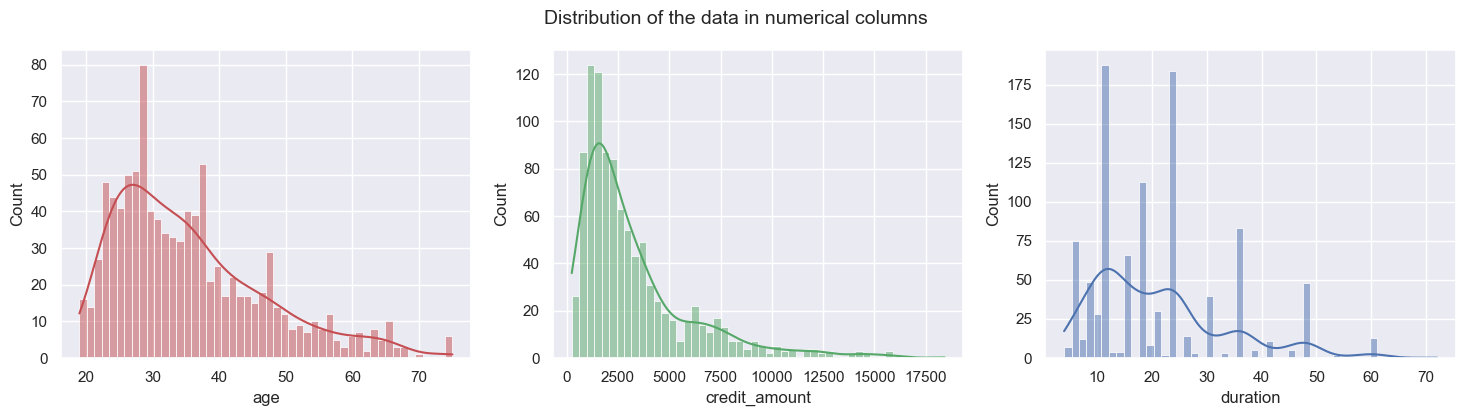

In [63]:
#Plotting the distribution of the numeric data
fig, ax = plt.subplots(1,3,figsize=(18,4))
i = 0
colors = ['r', 'g', 'b']

for col in num_col:
    plt.suptitle('Distribution of the data in numerical columns', fontsize=14)
    sns.histplot(encoded_df[col], bins=50, ax=ax[i], color = colors[i], kde=True)
    i += 1

From the graph of distribution, we can see that the data in numerical columns are skewed to the left, therefore we will use log transformation to get the normal distribution.

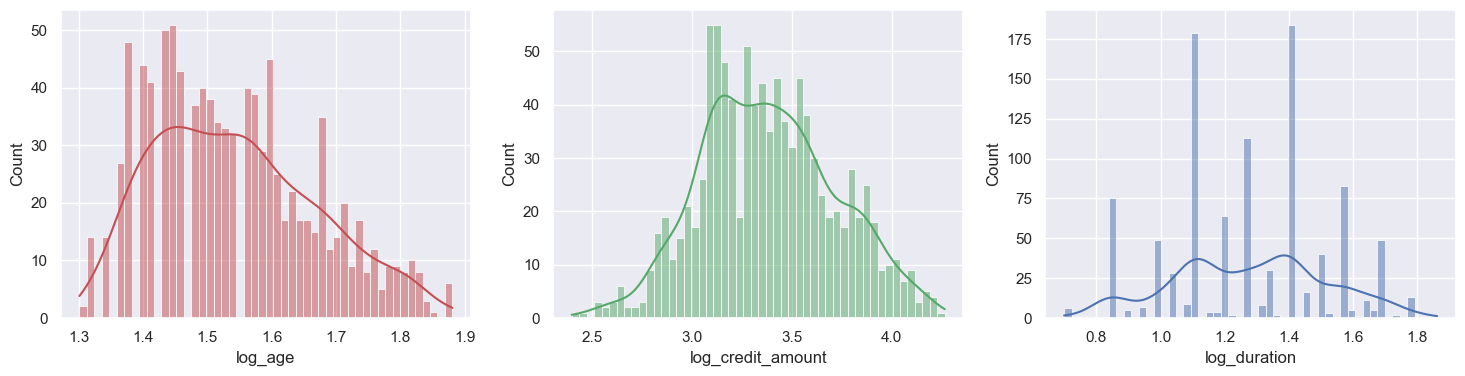

In [64]:
#log-transformation
fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = ['r', 'g', 'b']
for j in range (len (num_col)):
    var = num_col[j]
    transformed = "log_" + var
    encoded_df[transformed] = np.log10 (encoded_df[var]+1)
    sns.histplot(encoded_df[transformed], bins=50, ax=ax[j], color = colors[j], kde=True)


We can now see that data is normally distributed and can be used for further analysis.

Before feature scaling, let's do encoding on the risk column.

In [65]:
#Encoding binary variables in risk column
encoded_df['risk']= encoded_df['risk'].map({'good':0, 'bad':1})
encoded_df['risk'].head()

0    0
1    1
2    0
3    0
4    1
Name: risk, dtype: int64

### Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

X=encoded_df.drop(['risk', 'age', 'credit_amount', 'duration'], axis=1) #We have dropped numeric columns because we have already normalized the data, scaling it again may lead to right skewness.
y=encoded_df['risk'] #label

scaler = StandardScaler().fit(X.values)
transScalar = scaler.transform(X.values)
scaledF = pd.DataFrame(transScalar, columns = X.columns)
scaledF.head()

,sex_male,sex_female,job_2,job_1,job_3,job_0,housing_own,housing_free,housing_rent,saving_account_unavailable,...,purpose_education,purpose_furniture/equipment,purpose_car,purpose_business,purpose_domestic appliances,purpose_repairs,purpose_vacation/others,log_age,log_credit_amount,log_duration
0,-0.670280,0.670280,-0.149983,-0.5,0.766356,-0.416784,-0.347960,0.634448,-0.466933,-1.232433,...,-0.712949,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,2.282879,-0.933992,-1.822056
1,1.491914,-1.491914,-0.149983,-0.5,0.766356,-0.416784,-0.347960,0.634448,-0.466933,0.811403,...,-0.712949,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,-1.438777,1.163149,1.741206
2,-0.670280,0.670280,-0.149983,2.0,-1.304877,-0.416784,-0.347960,0.634448,-0.466933,0.811403,...,-0.712949,-0.110208,3.993639,-0.470108,-0.623610,-0.149983,-0.110208,1.227217,-0.181750,-0.688500
3,-0.670280,0.670280,-0.149983,-0.5,0.766356,-0.416784,2.873893,-1.576173,-0.466933,0.811403,...,-0.712949,-0.110208,-0.250398,2.127172,-0.623610,-0.149983,-0.110208,0.940950,1.525385,1.502020
4,-0.670280,0.670280,-0.149983,-0.5,0.766356,-0.416784,2.873893,-1.576173,-0.466933,0.811403,...,1.402626,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,1.491441,0.904761,0.508940


For Kmeans clustering, we have been informed to use only numeric value, therefore we are using normalized numeric columns for our anlaysis.

In [66]:
#Making seperate dataframe to store log-transformed numeric value
num_df = encoded_df[['log_age', 'log_credit_amount', 'log_duration']].copy()
num_df.head()

,log_age,log_credit_amount,log_duration
0,1.832509,3.068186,0.845098
1,1.361728,3.774663,1.690196
2,1.698970,3.321598,1.113943
3,1.662758,3.896692,1.633468
4,1.732394,3.687618,1.397940


In [67]:
#KMeans

from sklearn.cluster import KMeans

wcss = [] #Within-Cluster Sum of Square
K = range(1,11)
for k in K:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
    kmeans.fit(num_df) 
    wcss.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_

To find the optimal number of clusters, elbow method is used.

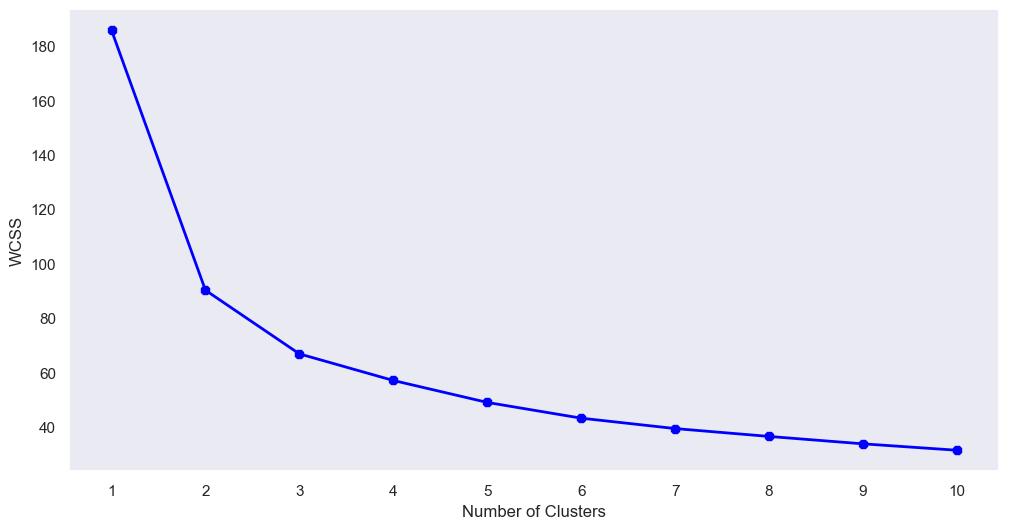

In [68]:
#Elbow plot

plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(K,wcss, linewidth=2, color="Blue", marker ="8")
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

From the graph drawn above, we can infere that the optimal number of clusters are 3, therefore, we will use K=3.

### Implement KMeans Clustering and PCA

In [72]:
km = KMeans(n_clusters=3)
km.fit(num_df)

km.inertia_

66.83009811896689

In [74]:
#Implementing PCA with 2 components 

from sklearn.decomposition import PCA 

y_means = KMeans(n_clusters=3, init='k-means++', max_iter= 650, n_init=100, random_state= 10).fit(num_df)
pca2 = PCA(n_components=2).fit(num_df)
pca2d = pca2.transform(num_df)
pcaDf = pd.DataFrame(data = pca2d, columns=['PC1','PC2']) #PC = Principal component 
pcaDf.head()

,PC1,PC2
0,0.488554,0.256586
1,-0.545869,-0.186042
2,0.134659,0.132400
3,-0.623402,-0.032294
4,-0.324486,0.075885


In [75]:
print("Explained variance of components :",pca2.explained_variance_)

Explained variance of components : [0.14262871 0.02753628]


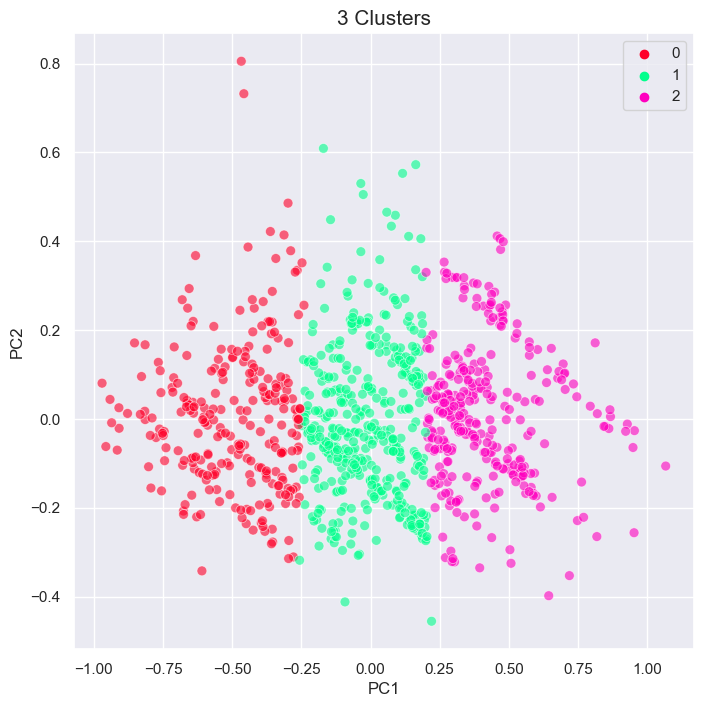

In [76]:
#Visualising clusters using 2 PCA components

plt.figure(figsize = (8,8))
sns.set()
sns.scatterplot(pcaDf['PC1'], pcaDf['PC2'],
                hue=km.labels_, 
                palette="gist_rainbow",
                s=50, alpha=0.6).set_title('3 Clusters', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

There's no significant boundary which can clearly segregate the clusters in 2d. However, we can see them in 3d and can clearly segregate the clusters.

### Implement KFOLD CV and use any classifier of your choosing and report the evaluation metrics

In [86]:
#splitting the dataset into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [94]:
## Helper Methods

def tune_hyperparameters(model, input_params, features, labels):
    cv = GridSearchCV(model, input_params, cv=10)
    cv.fit(features, labels)
    model_results(cv)

We have used Extreme Gradient Boosting classifier, because in comparison to other algorithms, the XGBoost model offers the best balance between prediction accuracy and computation time. Along with XGBoost, we have used StratifiedKFold where K = 10.

In [95]:
gb_parameters = {
    'n_estimators': [10, 50, 100, 250, 500],
    'learning_rate': [0.01, 0.1, 1, 10],
    'eval_metric': ['rmse', 'logloss', 'mlogloss']
}

tune_hyperparameters(model = XGBClassifier(), input_params = gb_parameters, features = X_train, labels= y_train)

Best Parameters: {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 500}

0.723 (+/- 0.068) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 10}
0.723 (+/- 0.09) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 50}
0.721 (+/- 0.102) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 100}
0.73 (+/- 0.111) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 250}
0.737 (+/- 0.108) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 500}
0.723 (+/- 0.119) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 10}
0.733 (+/- 0.092) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 50}
0.729 (+/- 0.102) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 100}
0.713 (+/- 0.11) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 250}
0.707 (+/- 0.118) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 500}
0.699 (+/- 0.124) for {'ev

In [96]:
xgb = XGBClassifier(learning_rate= 0.01, n_estimators= 500, eval_metric= 'rmse')
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='rmse', gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

In [98]:
cv = StratifiedKFold(n_splits=10)
metrics = ['accuracy', 'precision', 'recall', 'f1']
print("10 Fold Cross validation metrics for Extreme Gradient Boost Classifier:\n")
for m in metrics:
    score = cross_val_score(xgb, X_train, y_train, cv=cv, scoring=m)
    print(f"{m}: {round(score.mean()*100,2)}%")

10 Fold Cross validation metrics for Extreme Gradient Boost Classifier:

accuracy: 73.71%
precision: 59.42%
recall: 39.71%
f1: 47.18%
